In [1]:
###############################
# Import the necessary modules
###############################
import os
os.getcwd() 
import os.path
# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math
import time
# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt
#################################
import control
import affiche


pybullet build time: Oct 21 2025 17:40:50


In [2]:
# paramètres pour Pybullet
# the step time
dt = 0.001 # fréquence du simulateur
# Connet to pybullet and setup simulation parameters.
p.connect(p.GUI)
p.setGravity(0, 0, -0.81) #9.81
p.setPhysicsEngineParameter(fixedTimeStep= dt, numSubSteps=1)
# Zoom onto the robot.
p.resetDebugVisualizerCamera(1.0, 50, -35, (0., 0., 0.))
# Disable the gui controller as we don't use them.
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

#p.setRealTimeSimulation(1)

# récupérer le chemin du répertoire courant
path = os.getcwd()
print("Le répertoire courant est : " + path)
# récupérer le nom du répertoire courant
repn = os.path.basename(path)
print("Le nom du répertoire est : " + repn)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.loadURDF("plane.urdf")  # Load the ground plane
#
p.setAdditionalSearchPath(repn)

Le répertoire courant est : /Users/theojeanmart/Documents/tp-2
Le nom du répertoire est : tp-2


In [3]:
# Chargement du modèle urdf du robot
urdf_path = "./ur_description/urdf/ur3_robot.urdf"
robot= p.loadURDF(urdf_path, [0,0,0], [0,0,0,1],flags=p.URDF_USE_INERTIA_FROM_FILE, useFixedBase=True)
# we can now query some information about the robot
nj = p.getNumJoints(robot)
print('the robot has: ' + str(nj) + ' joints\n')
nj=nj-1
print("mais",nj, "joints articulaires\n")
print('the joint names are:')
for i in range(nj+1):
    print(p.getJointInfo(robot, i)[1].decode('UTF-8'))
control_joints = list(range(1, nj-2))   
print("Robot controlable joint",control_joints)
end_eff_index = control_joints[-1]
print("EE= ",end_eff_index)

the robot has: 10 joints

mais 9 joints articulaires

the joint names are:
world_joint
shoulder_pan_joint
shoulder_lift_joint
elbow_joint
wrist_1_joint
wrist_2_joint
wrist_3_joint
ee_fixed_joint
wrist_3_link-tool0_fixed_joint
base_link-base_fixed_joint
Robot controlable joint [1, 2, 3, 4, 5, 6]
EE=  6


In [4]:
 # function to solve forward kinematics
def solveForwardPositionKinematics(robot_id, joint):
    print('Forward position kinematics')
    # get end-effector link state
    eeState = p.getLinkState(robot_id, joint)
    link_trn, link_rot, com_trn, com_rot, frame_pos, frame_rot = eeState
#    eePose = list(link_trn) + list(p.getEulerFromQuaternion(link_rot))
    eePose = list(link_trn) + list(link_rot)
    print('End-effector pose:', eePose)
    return eePose


In [5]:
############################
#Init du robot
angle = np.array([0, -np.pi/2, np.pi/2, -np.pi/2, np.pi, 0]) #[0, 0, 0, -np.pi/2, np.pi, 0]
control.setJointPosition(robot, control_joints, angle, kp=1.0, kv=1.0)
time.sleep(10*dt)


Joint position controller


In [6]:
frame_base=[]
frame_base= affiche.draw_coordinate_frame([0,0,0],p.getQuaternionFromEuler([0, 0, 0]), length=0.5)

In [7]:
# Obtenir la position et l'orientation du link associé au joint
link_state = p.getLinkState(robot, 7)

# La pose est donnée par :
pos = link_state[0]  # Position (x, y, z)
orn = link_state[1]  # Orientation (quaternion [x, y, z, w])
ma= np.array(p.getMatrixFromQuaternion(orn))
#print(type(ma))
pp= np.array([pos[0],pos[1],pos[2]])
print(pp)
mat=np.array([ma[0:3],ma[3:6],ma[6:9]])
print(mat)

[0.296      0.028      0.39599998]
[[ 2.22044605e-16 -3.38231918e-07  1.00000000e+00]
 [-1.00000000e+00 -4.89697172e-12  2.77555756e-16]
 [ 4.89691621e-12 -1.00000000e+00 -3.38231918e-07]]


In [8]:
outil = solveForwardPositionKinematics(robot, 7)
print("Pose Outil=",outil)
# La pose est donnée par :
pos = outil[0:3]  # Position (x, y, z)
ori = outil[3:7]  # Orientation (quaternion [x, y, z, w])

Forward position kinematics
End-effector pose: [0.2959999999988042, 0.028000000000000094, 0.39599997529286984, 0.5000000845591966, -0.500000084556748, 0.4999999154432375, -0.4999999154407892]
Pose Outil= [0.2959999999988042, 0.028000000000000094, 0.39599997529286984, 0.5000000845591966, -0.500000084556748, 0.4999999154432375, -0.4999999154407892]


In [9]:
qinv = list(p.calculateInverseKinematics(robot, 7,pos, ori))
print(" qi sol du MGI pour UR3=", qinv, "type=",type(qinv))

control.setJointPosition(robot, control_joints, qinv, kp=1.0, kv=1.0)
outil = solveForwardPositionKinematics(robot, 7)
print("Pose 2 Outil=",outil)

 qi sol du MGI pour UR3= [-1.611000171004203e-12, -1.5707963271697472, 1.5707964098517373, -1.5707963266168665, 3.1415926733813344, -2.551762631081001e-07] type= <class 'list'>
Joint position controller
Forward position kinematics
End-effector pose: [0.2959999999073824, 0.027999999999523323, 0.3959999491813256, -0.5000001641199407, 0.5000001740140666, -0.49999982598667986, 0.49999983587919855]
Pose 2 Outil= [0.2959999999073824, 0.027999999999523323, 0.3959999491813256, -0.5000001641199407, 0.5000001740140666, -0.49999982598667986, 0.49999983587919855]


In [10]:
from part4_generation_articulaire import traj
from part1_loi_mouvement import calcul_loi_mouvement
from part2_trajectoire_operationnelle import calcul_trajectoire_operationnelle
from matrice_tn import generate_transformation_matrices, calcul_T06_global
from const_v import dh
from modele_differentiel import Jacob_geo
from utils import mgd_vers_simulation, simulation_vers_mgd

# Si les .py sont directement à côté du notebook, enlève "src." :
# from part4_generation_articulaire import traj
# from part1_loi_mouvement import calcul_loi_mouvement
# from part2_trajectoire_operationnelle import calcul_trajectoire_operationnelle
# from matrice_tn import generate_transformation_matrices, calcul_T06_global
# from const_v import dh
# from utils import mgd_vers_simulation, simulation_vers_mgd

import control  # ton control.py

In [11]:
# ==========================
# VI.1 - Génération des trajectoires
# ==========================

# Paramètres du cercle (reprends ceux de ta partie V)
O_cercle = np.array([0.4, 0.0, 0.45])   # centre du cercle plus haut en Z
R_cercle = 0.08                         # rayon légèrement réduit
V_cercle = 0.10                         # tu peux garder la même vitesse

# 1) Trajectoire articulaire via traj() du module part4_generation_articulaire
#    traj(O, R, V) -> time, q, qp, qpp  (q en convention MGD)
time_traj, q_traj, qp_traj, qpp_traj = traj(O_cercle, R_cercle, V_cercle, Debug=False)
q_traj   = np.asarray(q_traj)   # (N,6)

print("q_traj shape :", q_traj.shape)

# 2) Trajectoire opérationnelle théorique via V.1 + V.2

# calcul_loi_mouvement(R, V) -> time, s, s_dot, s_ddot, (t1,t2,tf)
time_s, s, s_dot, s_ddot, _ = calcul_loi_mouvement(R_cercle, V_cercle)

# calcul_trajectoire_operationnelle(O, R, s, s_dot, s_ddot)
X_cercle, dX_cercle, ddX_cercle = calcul_trajectoire_operationnelle(
    O_cercle, R_cercle, s, s_dot, s_ddot
)

X_cercle = np.asarray(X_cercle)  # (N,3)

# 3) Sécuriser : on prend la longueur commune
N = min(len(time_traj), len(X_cercle))
time_traj = time_traj[:N]
q_traj    = q_traj[:N, :]
X_cercle  = X_cercle[:N, :]

print("Nombre de pas N =", N)

q_traj shape : (1760, 6)
Nombre de pas N = 1760


In [12]:
# Nettoyage des anciens dessins debug avant VI.1
p.removeAllUserDebugItems()

In [13]:
# ==========================
# VI.1 - Simulation en position dans PyBullet (trace en direct)
# ==========================

dt_vi1 = float(time_traj[1] - time_traj[0])
p.setTimeStep(dt_vi1)

indices_joints = control_joints

q0_mgd = q_traj[0, :]
q0_sim = mgd_vers_simulation(q0_mgd)
control.setJointPosition(robot, indices_joints, q0_sim, kp=1.0, kv=1.0)
time.sleep(20 * dt_vi1)

X_robot   = np.zeros_like(X_cercle)
last_tip  = None   # pour tracer la ligne au fur et à mesure

ee_link_index = 7  # index de l'effecteur dans l'URDF

for k in range(N):
    # a) Consigne articulaire
    q_cible_mgd = q_traj[k, :]
    q_cible_sim = mgd_vers_simulation(q_cible_mgd)
    control.setJointPosition(robot, indices_joints, q_cible_sim, kp=1.0, kv=1.0)

    # b) Avancer la simulation
    p.stepSimulation()
    # time.sleep(dt_vi1)

    # c) Position de l'outil directement depuis PyBullet
    link_state = p.getLinkState(robot, ee_link_index)
    tip_pos    = np.array(link_state[0])   # position (x, y, z) outil dans le monde

    X_robot[k, :] = tip_pos

    # d) Trace en direct de la trajectoire
    if last_tip is not None:
        p.addUserDebugLine(
            last_tip,
            tip_pos,
            lineColorRGB=[0, 0, 1],  # bleu
            lineWidth=3,
            lifeTime=0
        )
    last_tip = tip_pos.copy()

Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint position controller
Joint positi

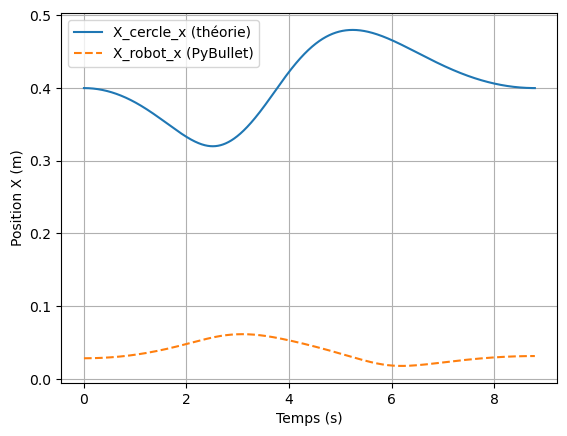

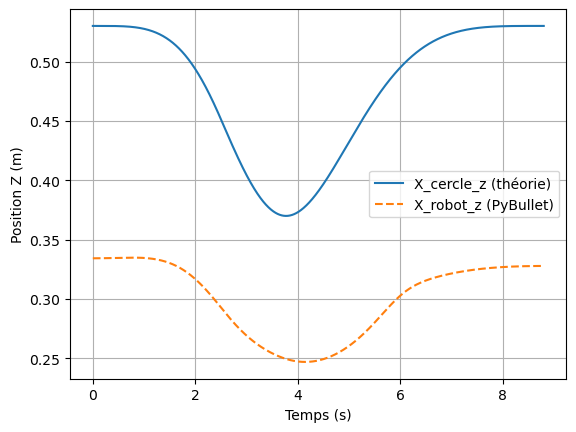

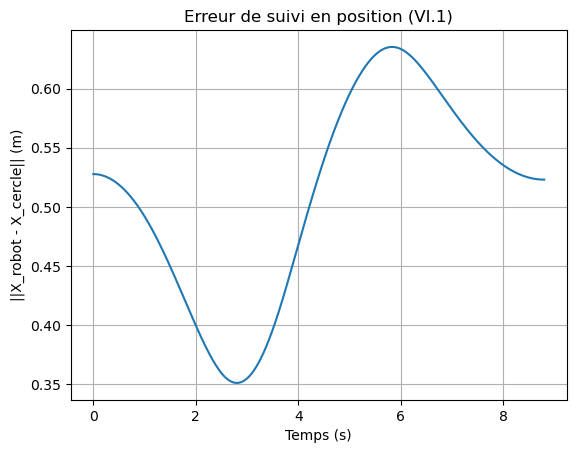

In [14]:
# ==========================
# VI.1 - Comparaison X_robot(t) vs X_cercle(t)
# ==========================

t = time_traj

# Composante X
plt.figure()
plt.plot(t, X_cercle[:, 0], label="X_cercle_x (théorie)")
plt.plot(t, X_robot[:, 0], "--", label="X_robot_x (PyBullet)")
plt.xlabel("Temps (s)")
plt.ylabel("Position X (m)")
plt.legend()
plt.grid(True)

# Composante Z
plt.figure()
plt.plot(t, X_cercle[:, 2], label="X_cercle_z (théorie)")
plt.plot(t, X_robot[:, 2], "--", label="X_robot_z (PyBullet)")
plt.xlabel("Temps (s)")
plt.ylabel("Position Z (m)")
plt.legend()
plt.grid(True)

# Erreur en norme
erreur = np.linalg.norm(X_robot - X_cercle, axis=1)

plt.figure()
plt.plot(t, erreur)
plt.xlabel("Temps (s)")
plt.ylabel("||X_robot - X_cercle|| (m)")
plt.title("Erreur de suivi en position (VI.1)")
plt.grid(True)
plt.show()

In [18]:
# ==========================
# VI.2 - Préparation (vitesses théoriques et commandes)
# ==========================

# On réutilise les mêmes paramètres que pour VI.1
O_cercle = np.array([0.4, 0.0, 0.3])
R_cercle = 0.10
V_cercle = 0.10

# 1) Trajectoire articulaire (déjà utilisée en VI.1)
#    -> time_traj, q_traj, qp_traj, qpp_traj
time_traj, q_traj, qp_traj, qpp_traj = traj(O_cercle, R_cercle, V_cercle, Debug=False)
q_traj   = np.asarray(q_traj)
qp_traj  = np.asarray(qp_traj)

N = len(time_traj)
print("N =", N)

# Pas de temps pour VI.2
dt_vi2 = float(time_traj[1] - time_traj[0])
p.setTimeStep(dt_vi2)

# 2) Vitesse opérationnelle théorique Xdot_cercle(t)
#    On recalcule la loi de mouvement et la trajectoire opérationnelle
time_s, s, s_dot, s_ddot, _ = calcul_loi_mouvement(R_cercle, V_cercle)
X_cercle, dX_cercle, ddX_cercle = calcul_trajectoire_operationnelle(O_cercle, R_cercle, s, s_dot, s_ddot)

dX_cercle = np.asarray(dX_cercle)   # (N_th, 3) théorique
N_th = len(dX_cercle)

# On tronque pour avoir la même longueur que q_traj
N = min(N, N_th)
time_traj = time_traj[:N]
q_traj    = q_traj[:N, :]
qp_traj   = qp_traj[:N, :]
dX_cercle = dX_cercle[:N, :]

print("Longueur commune N =", N)

# 3) Conversion de q_traj (MGD -> simulation) pour construire des vitesses de commande
q_traj_sim = np.zeros_like(q_traj)
for k in range(N):
    q_traj_sim[k, :] = mgd_vers_simulation(q_traj[k, :])

# Vitesses de commande en convention simulation : dérivée de q_traj_sim
qdot_cmd_sim = np.zeros_like(q_traj_sim)
for k in range(N-1):
    qdot_cmd_sim[k, :] = (q_traj_sim[k+1, :] - q_traj_sim[k, :]) / dt_vi2
qdot_cmd_sim[-1, :] = qdot_cmd_sim[-2, :]  # copie de la dernière valeur

print("qdot_cmd_sim shape :", qdot_cmd_sim.shape)

N = 2200
Longueur commune N = 2200
qdot_cmd_sim shape : (2200, 6)


Joint position controller


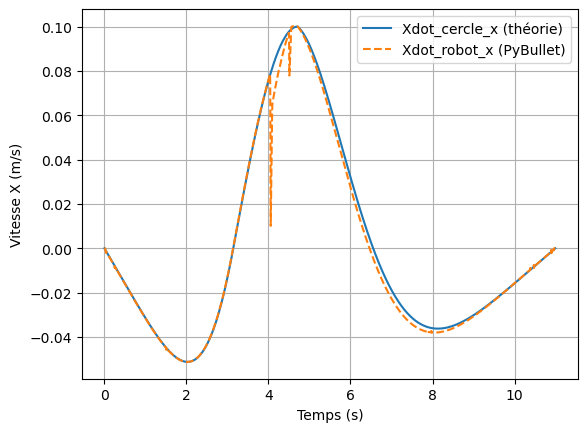

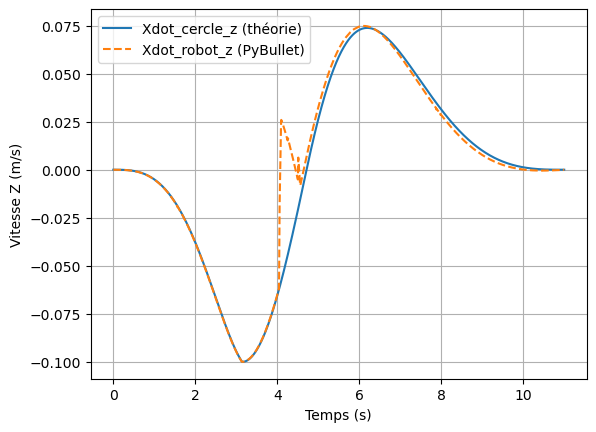

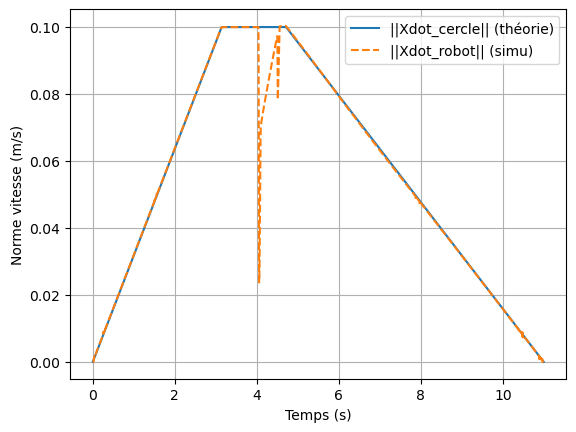

In [19]:
# ==========================
# VI.2 - Simulation en vitesse et Xdot_robot(t)
# ==========================

indices_joints = control_joints  # liste des 6 articulations UR3

# 1) Mettre le robot au point de départ (comme VI.1)
q0_mgd = q_traj[0, :]
q0_sim = mgd_vers_simulation(q0_mgd)
control.setJointPosition(robot, indices_joints, q0_sim, kp=1.0, kv=1.0)
time.sleep(20 * dt_vi2)

# 2) Tableaux pour stocker :
#    - q_mes_mgd[k]  : positions articulaires (en convention MGD)
#    - Xdot_robot[k] : vitesses opérationnelles reconstruites par la jacobienne
q_mes_mgd   = np.zeros_like(q_traj)
Xdot_robot  = np.zeros_like(dX_cercle)

# 3) Boucle de simulation : commande en VITESSE articulaire
torque_max = 50.0

for k in range(N):
    # a) Commande : vitesses articulaires en convention simulation
    v_cmd = qdot_cmd_sim[k, :]

    p.setJointMotorControlArray(
        bodyUniqueId=robot,
        jointIndices=indices_joints,
        controlMode=p.VELOCITY_CONTROL,
        targetVelocities=v_cmd.tolist(),
        forces=[torque_max] * len(indices_joints)
    )

    # b) Avancer la simulation
    p.stepSimulation()
    # time.sleep(dt_vi2)  # décommente pour visualiser

    # c) Lire les positions articulaire "mesurées" en convention simulation
    joint_positions, joint_velocities, joint_torques = control.getJointStates(robot, indices_joints)
    q_mes_sim = np.array(joint_positions)

    # d) Repasser en convention MGD pour utiliser ton modèle
    q_mes_mgd[k, :] = simulation_vers_mgd(q_mes_sim)

# 4) Calcul de qdot_mes_mgd par différences finies
qdot_mes_mgd = np.zeros_like(q_mes_mgd)
# différences centrées
qdot_mes_mgd[1:-1, :] = (q_mes_mgd[2:, :] - q_mes_mgd[:-2, :]) / (2.0 * dt_vi2)
# bords
qdot_mes_mgd[0, :]    = (q_mes_mgd[1, :] - q_mes_mgd[0, :]) / dt_vi2
qdot_mes_mgd[-1, :]   = (q_mes_mgd[-1, :] - q_mes_mgd[-2, :]) / dt_vi2

# 5) Calcul de Xdot_robot(k) = Jv(q_mes_mgd(k)) * qdot_mes_mgd(k)
for k in range(N):
    # matrices T0i
    mats = generate_transformation_matrices(q_mes_mgd[k, :], dh)
    # Jacobienne géométrique 6x6
    J_geo = Jacob_geo(mats, Debug=False)
    Jv = J_geo[0:3, :]   # partie linéaire (vitesse de translation)
    Xdot_robot[k, :] = Jv @ qdot_mes_mgd[k, :]

# 6) Tracés de comparaison Xdot_robot vs Xdot_cercle (dX_cercle)
t = time_traj

# Composante X
plt.figure()
plt.plot(t, dX_cercle[:, 0], label="Xdot_cercle_x (théorie)")
plt.plot(t, Xdot_robot[:, 0], "--", label="Xdot_robot_x (PyBullet)")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse X (m/s)")
plt.legend()
plt.grid(True)

# Composante Z
plt.figure()
plt.plot(t, dX_cercle[:, 2], label="Xdot_cercle_z (théorie)")
plt.plot(t, Xdot_robot[:, 2], "--", label="Xdot_robot_z (PyBullet)")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse Z (m/s)")
plt.legend()
plt.grid(True)

# Normes
norme_Xdot_theo   = np.linalg.norm(dX_cercle, axis=1)
norme_Xdot_robot  = np.linalg.norm(Xdot_robot, axis=1)

plt.figure()
plt.plot(t, norme_Xdot_theo, label="||Xdot_cercle|| (théorie)")
plt.plot(t, norme_Xdot_robot, "--", label="||Xdot_robot|| (simu)")
plt.xlabel("Temps (s)")
plt.ylabel("Norme vitesse (m/s)")
plt.legend()
plt.grid(True)
plt.show()